### Setup

In [84]:
import importlib
import polars as pl
import bioframe as bf
import numpy as np
import matplotlib.pyplot as plt

# Set the font family to Arial
# https://g.co/gemini/share/3898a74b2d77
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial'] # Add Arial to the sans-serif list

plt.rcParams.update({
    'font.size': 20,
})

SAMPLE = '200081' 
PB_CPG_TOOL_MODE = 'model'

pl.Config.set_tbl_rows(25)

from pathlib import Path

IHT_PHASED_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/data-shared/haplotype-maps/CEPH1463.GRCh38')
METH_READ_PHASED_DIR = Path(f'/scratch/ucgd/lustre-labs/quinlan/data-shared/dna-methylation/CEPH1463.GRCh38.hifi.{PB_CPG_TOOL_MODE}.read-backed-phased')

import sys

REPO_DIR = Path('/scratch/ucgd/lustre-labs/quinlan/u6018199/tapestry')
sys.path.append(str(REPO_DIR / 'src')) 

REFERENCE_GENOME = "hg38"

In [ ]:
TXT_IHT_BLOCKS = f"{IHT_PHASED_DIR}/CEPH1463.GRCh38.iht.sorted.txt" # multi-sample iht blocks file from gtg-ped-map/gtg-concordance
BED_METH_COMBINED = f"{METH_READ_PHASED_DIR}/{SAMPLE}.GRCh38.haplotagged.combined.bed.gz" # bed file from aligned_bam_to_cpg_scores for both haplotypes combined

## Get methylation levels at CpG sites 

In [ ]:
import get_meth_hap1_hap2
importlib.reload(get_meth_hap1_hap2)
from get_meth_hap1_hap2 import read_meth_level

DF_METH_COMBINED = read_meth_level(
    BED_METH_COMBINED, # type: ignore
    PB_CPG_TOOL_MODE
).rename({ "chromosome": "chrom" })

DF_METH_COMBINED

chrom,start,end,total_read_count,methylation_level
str,i64,i64,i64,f64
"""chr1""",10468,10469,13,0.868
"""chr1""",10470,10471,13,0.878
"""chr1""",10483,10484,13,0.929
"""chr1""",10488,10489,14,0.95
"""chr1""",10492,10493,13,0.964
"""chr1""",10496,10497,14,0.954
"""chr1""",10524,10525,14,0.951
"""chr1""",10541,10542,14,0.956
"""chr1""",10562,10563,14,0.932


## Get recombination blocks

In [ ]:
import get_all_phasing
importlib.reload(get_all_phasing)
from get_all_phasing import get_iht_blocks

def get_recombination_blocks(sample, txt_iht_blocks):
    df_iht_blocks = get_iht_blocks(sample, txt_iht_blocks)
    df_iht_blocks_sorted = df_iht_blocks.sort(["chrom", "start"])
    df_recombination_blocks = (
        df_iht_blocks_sorted
        .with_columns([
            pl.col("end").alias("recombination_block_start"),
            pl.col("start").shift(-1).over("chrom").alias("recombination_block_end"), # TODO: check if .over use is correct
        ])
        .with_columns(
            (pl.col("recombination_block_end") - pl.col("recombination_block_start")).alias("recombination_block_length")
        )
        .drop(["start", "end", "founder_label_pat", "founder_label_mat"])
        .filter(pl.col("recombination_block_length").is_not_null())
        .rename({
            "recombination_block_start": "start", 
            "recombination_block_end": "end", 
            "recombination_block_length": "length"
        })
    )
    return df_recombination_blocks

DF_RECOMBINATION_BLOCKS = get_recombination_blocks(SAMPLE, TXT_IHT_BLOCKS)
DF_RECOMBINATION_BLOCKS

chrom,start,end,length
str,i64,i64,i64
"""chr1""",1610923,1613420,2497
"""chr1""",3184712,3184788,76
"""chr1""",3200879,3203589,2710
"""chr1""",3398794,3399126,332
"""chr1""",5038259,5038659,400
"""chr1""",5097605,5097819,214
"""chr1""",6082247,6082326,79
"""chr1""",9098705,9098937,232
"""chr1""",9424618,9424760,142


## Get control intervals: a set of intervals that are outside recombination blocks, but have the same distribution of sizes 

In [75]:
def sample_intervals_from_complement(
    df: pl.DataFrame,
    reference_genome: str,
    rng_seed: int = 42
) -> pl.DataFrame:
    """
    For each interval in df, sample a random interval of the same length
    from the complement of df in the genome, using polars DataFrames where possible.

    Args:
        df: pl.DataFrame with columns ["chrom", "start", "end"]
        reference_genome: str, genome name for bioframe.fetch_chromsizes
        rng_seed: int, random seed for reproducibility

    Returns:
        pl.DataFrame with columns ["chrom", "start", "end"]
    """
    # Compute complement intervals 
    complement_intervals = bf.complement(
        df=df.select(["chrom", "start", "end"]).to_pandas(),
        view_df=bf.fetch_chromsizes(db=reference_genome),
    )
    complement_intervals["length"] = complement_intervals["end"] - complement_intervals["start"]
    complement_intervals = pl.from_pandas(complement_intervals)
    complement_intervals = complement_intervals.drop("view_region")
    
    # For reproducibility
    rng = np.random.default_rng(rng_seed)

    # Build a flat list of all complement intervals for sampling
    all_comps = list(complement_intervals.iter_rows(named=True))

    # Get original lengths
    original_lengths = df["end"] - df["start"]

    # Sample intervals
    sampled_intervals = []
    for length in original_lengths:
        # Find all complement intervals that are at least as long as "length"
        candidates = [iv for iv in all_comps if iv["length"] >= length]
        if not candidates:
            continue  # skip if no suitable region
        chosen_iv = candidates[rng.integers(len(candidates))]
        chrom, start, end = chosen_iv["chrom"], chosen_iv["start"], chosen_iv["end"]
        max_start = end - length
        if max_start == start:
            chosen_start = start
        else:
            chosen_start = rng.integers(start, max_start + 1)
        sampled_intervals.append({
            "chrom": chrom,
            "start": chosen_start,
            "end": chosen_start + length,
        })

    return (
        pl
        .DataFrame(sampled_intervals)
        .sort(["chrom", "start"])
        .with_columns(
            (pl.col("end") - pl.col("start")).alias("length")
        )
    )

DF_CONTROL_INTERVALS = sample_intervals_from_complement(
    DF_RECOMBINATION_BLOCKS,
    REFERENCE_GENOME
)
DF_CONTROL_INTERVALS

chrom,start,end,length
str,i64,i64,i64
"""chr1""",139834,140158,324
"""chr1""",1628256,1628301,45
"""chr1""",1787974,1788038,64
"""chr1""",3189026,3190503,1477
"""chr1""",3303522,3317898,14376
"""chr1""",5090655,5094968,4313
"""chr1""",5092463,5093190,727
"""chr1""",5374015,5374372,357
"""chr1""",6553637,6555082,1445


## Get methylation levels in recombination blocks, and in control intervals

In [112]:
def compute_methylation(df, df_meth): 
    df_intersected = bf.overlap(
        df.to_pandas(),
        df_meth.to_pandas(),
        how='inner',
        suffixes=('_df', '_meth')
    )
    df_intersected = pl.from_pandas(df_intersected)
    return (
        df_intersected
        .group_by(["chrom_df", "start_df", "end_df", "length_df"])
        .agg([
            pl.col("total_read_count_meth").mean().alias("mean_total_read_count"),
            pl.col("methylation_level_meth").mean().alias("mean_methylation_level"),
            pl.len().alias("num_cpg_sites"),
        ])
        .rename({
            "chrom_df": "chrom",
            "start_df": "start",
            "end_df": "end",
            "length_df": "length"
        })
        .with_columns(
            (pl.col("num_cpg_sites") / pl.col("length")).alias("num_cpg_sites_per_bp")
        )
        .sort(["chrom", "start"])
    )

DF_RECOMBINATION_BLOCKS_WITH_METH = compute_methylation(DF_RECOMBINATION_BLOCKS, DF_METH_COMBINED)
DF_RECOMBINATION_BLOCKS_WITH_METH

chrom,start,end,length,mean_total_read_count,mean_methylation_level,num_cpg_sites,num_cpg_sites_per_bp
str,i64,i64,i64,f64,f64,u32,f64
"""chr1""",1610923,1613420,2497,26.340426,0.834128,47,0.018823
"""chr1""",3184712,3184788,76,22.5,0.5565,2,0.026316
"""chr1""",3200879,3203589,2710,26.942857,0.896886,70,0.02583
"""chr1""",3398794,3399126,332,37.916667,0.88,12,0.036145
"""chr1""",5038259,5038659,400,41.75,0.809,4,0.01
"""chr1""",5097605,5097819,214,38.0,0.7618,5,0.023364
"""chr1""",6082247,6082326,79,37.0,0.883,5,0.063291
"""chr1""",9098705,9098937,232,49.0,0.923667,3,0.012931
"""chr1""",9424618,9424760,142,29.333333,0.822333,3,0.021127


In [114]:
DF_CONTROL_INTERVALS_WITH_METH = compute_methylation(DF_CONTROL_INTERVALS, DF_METH_COMBINED)
DF_CONTROL_INTERVALS_WITH_METH

chrom,start,end,length,mean_total_read_count,mean_methylation_level,num_cpg_sites,num_cpg_sites_per_bp
str,i64,i64,i64,f64,f64,u32,f64
"""chr1""",139834,140158,324,28.0,0.905583,12,0.037037
"""chr1""",1628256,1628301,45,30.0,0.967,3,0.066667
"""chr1""",1787974,1788038,64,33.0,0.96,3,0.046875
"""chr1""",3189026,3190503,1477,27.530612,0.837082,49,0.033175
"""chr1""",3303522,3317898,14376,37.038554,0.810386,415,0.028868
"""chr1""",5090655,5094968,4313,37.5,0.805667,6,0.001391
"""chr1""",5374015,5374372,357,32.0,0.895,2,0.005602
"""chr1""",6553637,6555082,1445,33.256881,0.094982,109,0.075433
"""chr1""",9477747,9478721,974,32.5,0.915833,18,0.01848


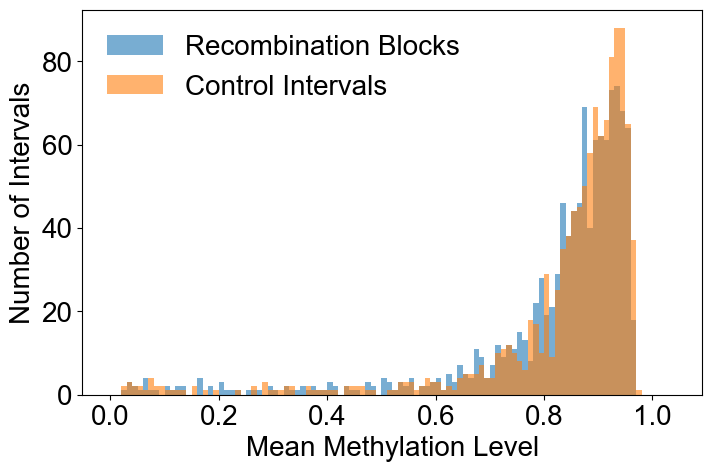

In [103]:
def downsample_to_equal_size(df1, df2, seed=42):
    """
    Downsample the larger of two dataframes to match the size of the smaller one.
    Returns the two dataframes, both with the same number of rows.
    """
    n1 = len(df1)
    n2 = len(df2)
    if n1 < n2:
        df2 = df2.sample(n=n1, shuffle=True, seed=seed)
    else:
        df1 = df1.sample(n=n2, shuffle=True, seed=seed)
    return df1, df2

def plot_histograms(
    df_recomb, 
    df_control, 
    column="mean_methylation_level", 
    bins=np.arange(0, 1.05, 0.01), 
    xlabel=None, 
    ylabel="Number of Intervals", 
    legend_labels=("Recombination Blocks", "Control Intervals"),
    figsize=(8, 5)
):
    """
    Plot histograms for a specified column from two dataframes.

    Args:
        df_recomb: DataFrame for recombination blocks.
        df_control: DataFrame for control intervals.
        column: The column to plot histograms for.
        bins: Number of bins for the histogram.
        xlabel: Label for the x-axis. If None, uses the column name.
        ylabel: Label for the y-axis.
        legend_labels: Tuple of labels for the legend.
        figsize: Figure size.
    """
    df_recomb, df_control = downsample_to_equal_size(df_recomb, df_control)

    plt.figure(figsize=figsize)
    plt.hist(
        df_recomb[column], 
        bins=bins, 
        alpha=0.6, 
        label=legend_labels[0]
    )
    plt.hist(
        df_control[column], 
        bins=bins, 
        alpha=0.6, 
        label=legend_labels[1]
    )
    plt.xlabel(xlabel if xlabel is not None else column)
    plt.ylabel(ylabel)
    plt.legend(frameon=False)

plot_histograms(
    DF_RECOMBINATION_BLOCKS_WITH_METH, 
    DF_CONTROL_INTERVALS_WITH_METH, 
    column="mean_methylation_level", 
    xlabel="Mean Methylation Level"
)

In [87]:
# TODO: why do these distributions look so right-skewed? 

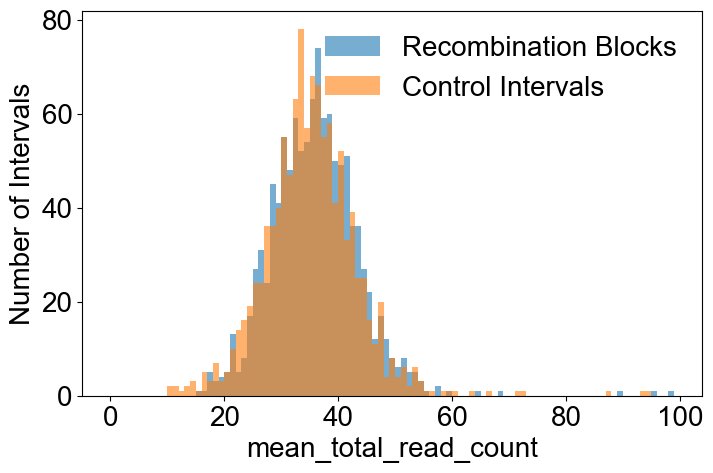

In [107]:
plot_histograms(
    DF_RECOMBINATION_BLOCKS_WITH_METH, 
    DF_CONTROL_INTERVALS_WITH_METH, 
    column="mean_total_read_count", 
    xlabel="mean_total_read_count",
    bins=np.arange(0, 100, 1)
)

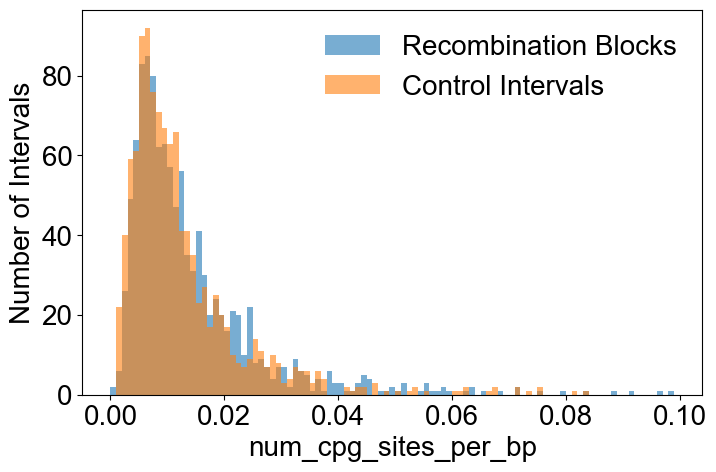

In [ ]:
plot_histograms(
    DF_RECOMBINATION_BLOCKS_WITH_METH, 
    DF_CONTROL_INTERVALS_WITH_METH, 
    column="num_cpg_sites_per_bp", 
    xlabel="num_cpg_sites_per_bp",
    bins=np.arange(0, 0.1, 0.001)
)